cSMC

In [1]:
import jax.numpy as jnp
from jax import random
from jax import grad, vmap, jit
from matplotlib import pyplot as plt
import seaborn as sns
from jax.config import config; config.update("jax_enable_x64", True)
from jax.scipy.stats import multivariate_normal
from melange.gaussians import unnormalized_Normal_logp
%matplotlib inline

as a test, i am going to anneal between two gaussians centered at zero over 10 steps. the prior has a variance of 2 and the posterior has a variance of 1.



In [2]:
from melange.tests.utils import get_nondefault_potential_initializer, checker_function
from melange.smc import vSIS_lower_bound, SIS, generate_trajs, SIS_logW, bootstrap_logZ
import tqdm
from jax.lax import cond
import numpy as np
from melange.csmc import *

#define some parameters
N,T,Dx = 1000, 10, 1
potential, (mu, cov), dG = get_nondefault_potential_initializer(Dx)
cov = cov[0]
dt=1e-2

#define some _vanilla_ A, b fns
A_fn = lambda x, params: params
b_fn = lambda x, params: jnp.zeros(Dx)

potential_params = jnp.linspace(0,1,T)[..., jnp.newaxis] #define the potential parameters

prop_params = {
               'potential_params': potential_params,
               'forward_potential_params': potential_params,
               'backward_potential_params': potential_params[1:],
               'dt': dt
               } #potential parameters dictionary goes here
init_params = {'mus': jnp.array([mu]), 
               'covs': jnp.array([cov]),
               'mixture_weights': jnp.array([1.])} #define the initial params
model_params=None #there are no model parameters
y=jnp.arange(T) #the y data aren't important. just know that there are the same number of them as there are data
rs = random.PRNGKey(6) #define a random number 

#create the csmc container object
smc_obj= StaticULAControlledSMC(N, 
                            potential=potential,
                            forward_potential=potential, 
                            backward_potential=potential, 
                            A_fn = A_fn, #A_fn=lambda x, p: jnp.zeros((Dx, Dx)), 
                            b_fn = b_fn, #b_fn = lambda x, p: jnp.zeros(Dx),
                            params_len=1,
                            Dx=1,
                            T=T,
                            max_twists=10,
                            prop_params=prop_params,
                            init_params=init_params,
                            model_params=model_params,
                            y=None
                           ) #create a controlled smc class




DEBUG:absl:Initializing backend 'interpreter'
DEBUG:absl:Initializing backend 'cpu'
DEBUG:absl:Initializing backend 'gpu'
DEBUG:absl:Error initializing backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
DEBUG:absl:Compiling _where for args (ShapedArray(bool[1,1]), ShapedArray(float64[1]), ShapedArray(float64[1])).
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
Level 9:absl:get_compile_options: num_replicas=1 nu

can we wrap all of this functionality into something easy?


In [3]:
class CSMCWrapper(object):
    """
    container for monitoring csmc
    """
    def __init__(self, csmc_object, rs):
        """
        wrap
        """
        assert csmc_object.twisting_iteration == 1
        self.csmc_object = csmc_object
        self.rs = rs
        
        self.Xs_container = []
        self.agg_works = []
        self.bootstrap_logZs = []
        self.out_containers = []
    
    def run_twist_iteration(self):
        re_rs, run_rs = random.split(self.rs)
        self.rs = re_rs
        Xs, works = twisted_smc(self.csmc_object, run_rs, aggregate_works=False)
        bootstrap_logZs = bootstrap_logZ(works)
        adp_fns_dict = self.csmc_object.get_ADP_fn()
        out_container = adp_fns_dict['ADP'](Xs, works, verbose=True)
        self.csmc_object.update_cSMC(new_A_params=out_container['out_A_params'],
                                     new_b_params=out_container['out_b_params'],
                                     new_A0=out_container['out_A0'],
                                     new_b0=out_container['out_b0']
                                    )
        
        #report
        self.Xs_container.append(np.asarray(Xs))
        self.agg_works.append(np.asarray(jnp.cumsum(works, axis=0)))
        self.bootstrap_logZs.append(np.asarray(bootstrap_logZs))
        self.out_containers.append(out_container)
        
    

In [4]:
controller = CSMCWrapper(smc_obj, rs = random.PRNGKey(42))
for i in range(4):
    controller.run_twist_iteration()

DEBUG:absl:Compiling _split for args (ShapedArray(uint32[2]),).
DEBUG:csmc:generating SMC variable initializer function
DEBUG:absl:Compiling _split for args (ShapedArray(uint32[2]),).
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
DEBUG:absl:Compiling _where for args (ShapedArray(bool[]), ShapedArray(float64[], weak_type=True), ShapedArray(float64[], weak_type=True)).
DEBUG:absl:Compiling _where for args (ShapedArray(bool[]), ShapedArray(float64[], weak_type=True), ShapedArray(float64[])).
DEBUG:absl:Compiling _split for args (ShapedArray(uint32[1000,2]),).
DEBUG:absl:Compiling _cumulative_reduction for args (ShapedArray(float64[1]),).
DEBUG:absl:Compiling _uniform for args (ShapedArray(uint32[1000,2]), ShapedArray(float64[], weak_type=True), ShapedArray(float64[], weak_type=True)).
DEBUG:absl:Compiling _searchsorted for args (ShapedArray(float64[1]), ShapedArray(float64[1000])).
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1

let's plot the distribution of bootstrapped logZs

Text(0.5, 1.0, 'bootstrapped logZs')

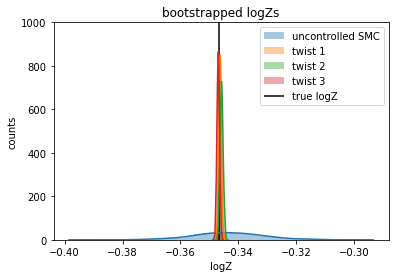

In [6]:
sns.distplot(controller.bootstrap_logZs[0], label=f"uncontrolled SMC")
sns.distplot(controller.bootstrap_logZs[1], label=f"twist 1")
sns.distplot(controller.bootstrap_logZs[2], label=f"twist 2")
sns.distplot(controller.bootstrap_logZs[3], label = f"twist 3")
plt.vlines(dG, 0,1000, label=f"true logZ")
plt.ylim(0, 1000)
plt.legend()
plt.ylabel('counts')
plt.xlabel(f"logZ")
plt.title(f"bootstrapped logZs")

can we plot the starting and final distributions?

In [7]:
from scipy.stats import multivariate_normal

In [8]:
support = np.linspace(-4,4,100)[..., np.newaxis]
init_untwist_dist = np.exp(multivariate_normal.logpdf(support, mean = mu, cov = cov))
_, _, (twist_mu0, twist_cov0) = get_twisted_gmm(controller.csmc_object.init_params['mixture_weights'], 
                                               controller.csmc_object.init_params['mus'],
                                               controller.csmc_object.init_params['covs'],
                                               controller.csmc_object.A0,
                                               controller.csmc_object.b0)
init_twist_dist = np.exp(multivariate_normal.logpdf(support, mean = twist_mu0[0], cov = twist_cov0[0]))
final_dist = np.exp(multivariate_normal.logpdf(support, mean = mu, cov = np.array([1.])))



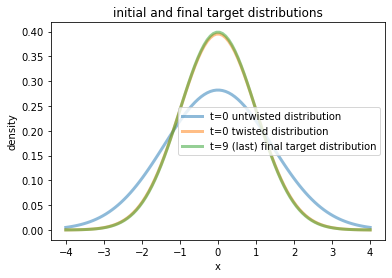

In [9]:
plt.plot(support, init_untwist_dist, lw=3, alpha=.5, label = f"t=0 untwisted distribution")
plt.plot(support, init_twist_dist, lw=3, alpha=.5, label=f"t=0 twisted distribution")
plt.plot(support, final_dist, lw=3, alpha=.5, label=f"t=9 (last) final target distribution")
plt.xlabel(f"x")
plt.ylabel(f"density")
plt.title(f"initial and final target distributions")
plt.legend()

so it would appear that we can recover the exact posterior since the prior family includes the posterior.

In a physics context, this is akin to annealing between an oscillator of spring constant $K_0$ to a spring constant of $2K_0$

Now, I'll attempt to anneal between two springs of a constant $K_0$ but from $r_0=0$ to $r_1=2$

In [99]:
def new_potential(pos, parameter):
    mod_parameter = parameter[0]
    dim = pos.shape[0]
    r0, r1 = jnp.array([0.0]), jnp.array([2.0])
    k0 = jnp.diag(jnp.ones(dim))
    delta0, delta1 = pos-r0, pos-r1
    return 0.5*((1. - mod_parameter) * jnp.dot(jnp.dot(delta0, k0), delta0) + mod_parameter*jnp.dot(jnp.dot(delta1, k0), delta1))

#make a dummy potential for fun
def dummy_potential(pos, parameter):
    return 0.

In [170]:
#wrap an initializer
def get_test_potential_initializer(dimension):
    potential = new_potential
    mu, cov = jnp.zeros(dimension), jnp.diag(jnp.ones(dimension))
    dG = 0.
    return potential, (mu, cov), dG

#define some _vanilla_ A, b fns
A_fn = lambda x, params: params
b_fn = lambda x, params: params


next, I'll anneal between a gaussian with a covariance of 1 centered at 0 and anneal to the same gaussian, except centered at x=2 (again, over 10 steps)

In [268]:
N,T,Dx = 10000, 10, 1
potential, (mu, cov), dG = get_test_potential_initializer(Dx)
cov = cov[0]
potential_params = jnp.linspace(0,1,T)[..., jnp.newaxis] #define the potential parameters

prop_params = {
               'potential_params': potential_params,
               'forward_potential_params': potential_params,
               'backward_potential_params': potential_params[1:],
               'dt': dt
               } #potential parameters dictionary goes here
init_params = {'mus': jnp.array([mu]), 
               'covs': jnp.array([cov]),
               'mixture_weights': jnp.array([1.])} #define the initial params
model_params=None #there are no model parameters
y=jnp.arange(T) #the y data aren't important. just know that there are the same number of them as there are data
rs = random.PRNGKey(6) #define a random number 

#create the csmc container object
smc_obj= StaticULAControlledSMC(N, 
                            potential=potential,
                            forward_potential=potential, 
                            backward_potential=potential, 
                            A_fn = A_fn,
                            b_fn = b_fn,
                            params_len=1,
                            Dx=1,
                            T=T,
                            max_twists=10,
                            prop_params=prop_params,
                            init_params=init_params,
                            model_params=model_params,
                            y=None
                           ) #create a controlled smc class

DEBUG:csmc:instantiating super
DEBUG:csmc:define A, b functions
DEBUG:csmc:getting the parameter lengths
DEBUG:csmc:getting x dimension
DEBUG:csmc:getting the terminal time
DEBUG:csmc:getting the maximum number of twists
DEBUG:csmc:getting prop_params
DEBUG:csmc:getting init_params
DEBUG:csmc:getting model_params
DEBUG:csmc:getting y
DEBUG:csmc:define twisting parameters and parameter caches
DEBUG:csmc:define psi twisting functions


In [269]:
#29 random key
controller = CSMCWrapper(smc_obj, rs = random.PRNGKey(27))
for i in range(4):
    controller.run_twist_iteration()

DEBUG:csmc:generating SMC variable initializer function
DEBUG:csmc:generating simulation propagation function
100%|██████████| 9/9 [00:00<00:00, 19.81it/s]
DEBUG:csmc:generating SMC log weight initializer function
DEBUG:csmc:generating the log weight calculator
100%|██████████| 1000/1000 [00:02<00:00, 444.52it/s]
DEBUG:csmc:generating approximate dynamic programming functions
DEBUG:csmc:iterating backward...
100%|██████████| 9/9 [00:02<00:00,  3.02it/s]
DEBUG:csmc:conducting t=0 twist...
DEBUG:csmc:minimizer message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
DEBUG:csmc:finished optimizations; terminating...
DEBUG:csmc:updating cSMC with new parameters
DEBUG:csmc:cacheing parameters at index 0
DEBUG:csmc:generating SMC variable initializer function
DEBUG:csmc:generating simulation propagation function
100%|██████████| 9/9 [00:00<00:00, 14.91it/s]
DEBUG:csmc:generating SMC log weight initializer function
DEBUG:csmc:generating the log weight calculator
100%|██████████| 1000/1000

Text(0.5, 1.0, 'bootstrapped logZs')

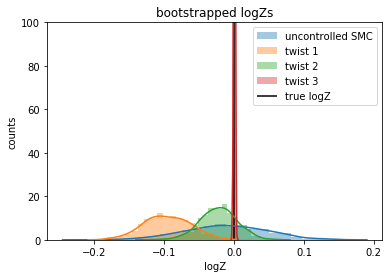

In [271]:
sns.distplot(controller.bootstrap_logZs[0], label=f"uncontrolled SMC")
sns.distplot(controller.bootstrap_logZs[1], label=f"twist 1")
sns.distplot(controller.bootstrap_logZs[2], label=f"twist 2")
sns.distplot(controller.bootstrap_logZs[3], label = f"twist 3")
#sns.distplot(controller.bootstrap_logZs[4], label = f"twist 4")
#sns.distplot(controller.bootstrap_logZs[5], label = f"twist 5")
#sns.distplot(controller.bootstrap_logZs[6], label = f"twist 5")
plt.vlines(dG, 0,1000, label=f"true logZ")
plt.ylim(0, 100)
plt.legend()
plt.ylabel('counts')
plt.xlabel(f"logZ")
plt.title(f"bootstrapped logZs")

In [274]:
support = np.linspace(-4,4,100)[..., np.newaxis]
init_untwist_dist = np.exp(multivariate_normal.logpdf(support, mean = mu, cov = cov))
_, _, (twist_mu0, twist_cov0) = get_twisted_gmm(controller.csmc_object.init_params['mixture_weights'], 
                                               controller.csmc_object.init_params['mus'],
                                               controller.csmc_object.init_params['covs'],
                                               controller.csmc_object.A0,
                                               controller.csmc_object.b0)
init_twist_dist = np.exp(multivariate_normal.logpdf(support, mean = twist_mu0[0], cov = twist_cov0[0]))
final_dist = np.exp(multivariate_normal.logpdf(support, mean = 2., cov = np.array([1.])))



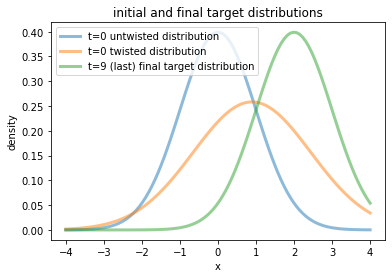

In [276]:
plt.plot(support, init_untwist_dist, lw=3, alpha=.5, label = f"t=0 untwisted distribution")
plt.plot(support, init_twist_dist, lw=3, alpha=.5, label=f"t=0 twisted distribution")
plt.plot(support, final_dist, lw=3, alpha=.5, label=f"t=9 (last) final target distribution")
plt.xlabel(f"x")
plt.ylabel(f"density")
plt.title(f"initial and final target distributions")
plt.legend()

cool

NOTES:
- in both of these examples, the twisting functions that control the variance and mean of the propagations are _independent_ of the position of the latent variable, which is perhaps an unnecessary constraint
- to fix this ^, I will write more expressive functions (while maintaining the constraint that the covariance must be positive-definite)
- I need to fix some of the loggings since they are perhaps a little overly verbose
